In [31]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout
from keras.models import Model
import random

In [32]:
np.random.seed(0)

In [33]:
(X_train, y_train), (X_test, y_test) = mnist.load_data() # 60000 training datasets and 10000 test datasets

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape[0])

(60000, 28, 28)
(10000, 28, 28)
60000


In [35]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (28, 28)), "The dimenstions of the images are mpt 28x28."
assert(X_test.shape[1:] == (28, 28)), "The dimenstions of the images are mpt 28x28."

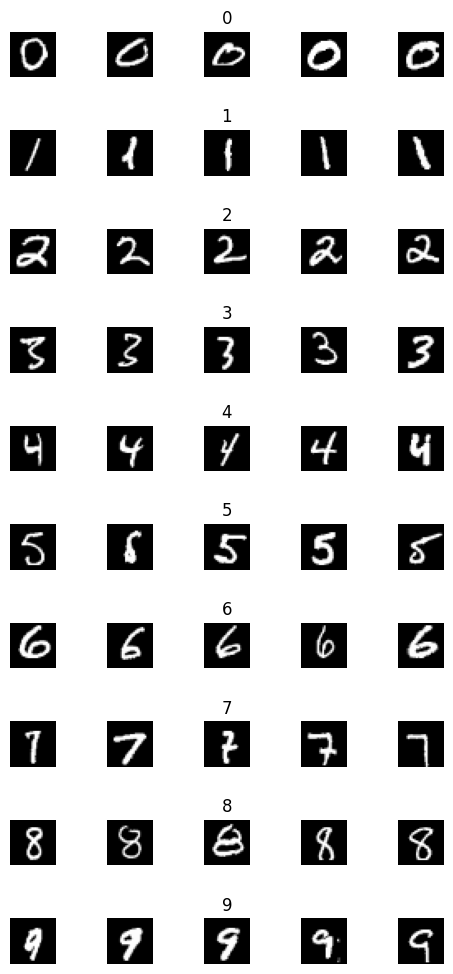

In [36]:
num_of_samples = []

cols = 5
num_classes = 10
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 10)) # 5 x 10 크기의 여러가지 fig를 생성함.
fig.tight_layout() # 각 fig 가 overlap 되지 않게 해줌
for i in range(cols):
  for j in range(num_classes):
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap = plt.get_cmap("gray"))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j));
      num_of_samples.append(len(x_selected))

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


Text(0, 0.5, 'Number of images')

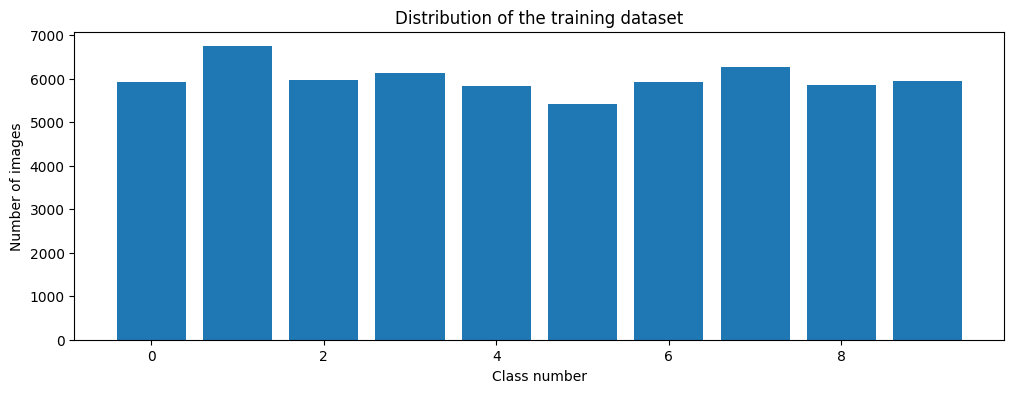

In [37]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

In [38]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

In [39]:
y_train = to_categorical(y_train, 10) # one hot encoding 실행으로 카테고리의 연관성을 배제.
y_test = to_categorical(y_test, 10)

In [40]:
X_train = X_train/255 # 0~255 는 분산이 너무 커서 sigmoid나 softmax값 구하기가 힘듬(eg. e^255 = 엄청 큰 수). 따라서 0 ~ 1사이로 normalization을 함.
X_test = X_test/255

In [41]:
def leNet_model(): # 1998년에 만들어진 유명한 lenet model 만들기
  model = Sequential()
  model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu')) # 5 x 5 사이즈의 다른 필터를 30번 적용. 따라서 24 x 24 의 이미지가 30개 나온다. 5 x 5 x 30 + 30(bias) = 780개의 adjustable한 parameters가 있다
  # stride 와 padding 인자를 추가로 줄 수 있다. stride 는 kernel이 옆으로 얼마나 움직이는지(default is 1). padding 은 가장자리의 정보를 retain 하기 위해 이미지 주변에 0을 붙이는 것을 말한다.
  # MNIST dataset에는 가장자리에 의미없는 검은색 픽셀만 있으므로 디폴트 값인 'valid'(padding 추가 안함) 으로 놔둔다. 
  model.add(MaxPooling2D(pool_size=(2, 2))) # 2 x 2 사이즈의 kernel에서 maximum value를 기록함으로써 가장 중요한 feature을 기록한다. 이 프로세스로 인해 이미지는 점점 알아볼 수 없게 되지만 feature정보는 남게 된다. 또한 이미지의
  # 의미 없는 정보를 배제함으로써 overfitting을 방지할 수 있다. 나오는 결과는 12 x 12 가 30개.
  model.add(Conv2D(15, (3, 3), activation='relu')) # gpu의 과부하를 줄이기 위해 15개의 3 x 3 필터를 적용한다. 그럼에도 15(필터갯수) x 30(전과정에서 도출된 이미지들) x 3 x 3 (필터사이즈) + 15(bias) = 4065 이 된다.
  # 도출되는 값은 10 x 10 x 15
  model.add(MaxPooling2D(pool_size=(2, 2))) # 도출되는 값은 5 x 5 x 15
  model.add(Flatten()) # fully connected layer 에 input해 주기 위해서 flatten 하는 과정을 넣어줌. Flatten layer. 도출되는 값은 5 x 5 x 15 = 375 (행렬 형태가 아니라 flatten 됨)
  model.add(Dense(500, activation='relu')) # relu는 matrix multiplication의 linearity 를 없애기 위한 함수(y=0 if x <=0 else y = x). sigmoid나 tanh함수는 derivative(기울기)가 0보다 크고 1 보다 작은 경우가 많기 때문에
  # 에러를 계속 곱하는 feedforwarding 특성상 gradient descent 값(최적화를 위해 나아가는 값) 이 0에 가깝게 수렴하면서 굉장히 느려질 수 있다. 하지만 relu는 derivative 가 1 이기 때문에 이런 문제에서 자유롭다.
  model.add(Dropout(0.5)) # overfitting을 방지하기 위해 50%의 노드를 배제한다. 이는 자주 쓰이는 노드 말고 안 쓰이는 노드도 learning을 하게 만듬으로써 model전체가 generalization된다.
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [42]:
model = leNet_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 30)        780       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 30)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 15)        4065      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 15)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 375)               0         
                                                                 
 dense_2 (Dense)             (None, 500)              

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [43]:
history = model.fit(X_train, y_train, epochs = 10, validation_split=0.1, batch_size=400, verbose=1, shuffle=1) # validation set은 hyperparameters를 조정하기 위해 사용됨.(eg. learning rate, nubmer of nodes in each layer
# number of layers). 따라서 overfitting(특징을 추출하는 것이 아닌 training 데이터만 달달 외워서 새로운 유형에는 틀리는 상황) 을 방지하고 network가 보지 못한 새로운 데이터에 대해 generalization을 하게 됨.
# process : training set으로 standard parameter(weight, bias)들을 최적화하는 것을 목표로함. 하지만 이 과정에서 training set만 학습하는 것을 목표로하기 때문에 overfitting이 발생할 수 있음. 그래서 
# 한번도 보지 못한 validation set을 사용해 hyperparameters를 조정함. 이 과정에서 validation set의 정보를 model 이 알게 되므로(이정보 또한 training이 되므로) 진정으로 보지 못한 test set으로 마지막 테스트를 하는것.
# 물론 test set으로는 최적화를 하지 않는다.

Epoch 1/10
135/135 [==============================] - 1s 7ms/step - loss: 0.2284 - accuracy: 0.9268 - val_loss: 0.0573 - val_accuracy: 0.9832
Epoch 2/10
135/135 [==============================] - 1s 7ms/step - loss: 0.0690 - accuracy: 0.9787 - val_loss: 0.0366 - val_accuracy: 0.9887
Epoch 3/10
135/135 [==============================] - 1s 7ms/step - loss: 0.0564 - accuracy: 0.9830 - val_loss: 0.0453 - val_accuracy: 0.9875
Epoch 4/10
135/135 [==============================] - 1s 6ms/step - loss: 0.0473 - accuracy: 0.9845 - val_loss: 0.0383 - val_accuracy: 0.9897
Epoch 5/10
135/135 [==============================] - 1s 7ms/step - loss: 0.0468 - accuracy: 0.9853 - val_loss: 0.0359 - val_accuracy: 0.9910
Epoch 6/10
135/135 [==============================] - 1s 6ms/step - loss: 0.0428 - accuracy: 0.9867 - val_loss: 0.0359 - val_accuracy: 0.9897
Epoch 7/10
135/135 [==============================] - 1s 6ms/step - loss: 0.0421 - accuracy: 0.9867 - val_loss: 0.0394 - val_accuracy: 0.9895
Epoch 

Text(0.5, 0, 'epoch')

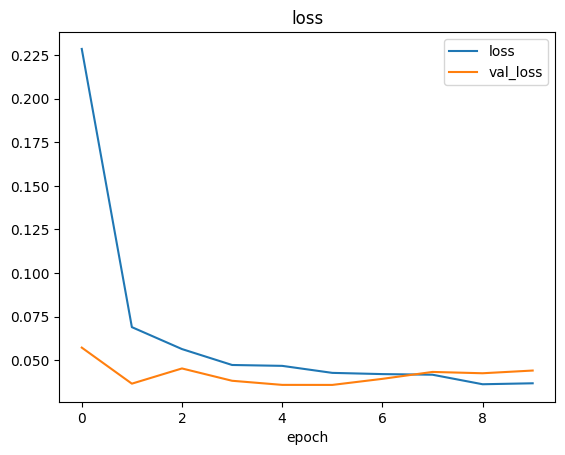

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

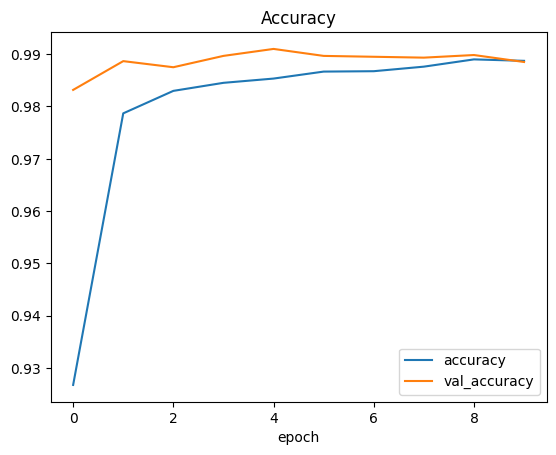

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [46]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0]) # evaluation of loss function, error
print('Test accuracy:', score[1]) # accuracy

Test score: 0.03780058026313782
Test accuracy: 0.9887999892234802


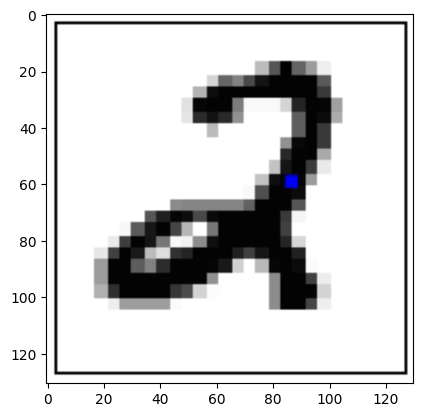

In [47]:
import requests
from PIL import Image
url = 'https://colah.github.io/posts/2014-10-Visualizing-MNIST/img/mnist_pca/MNIST-p1815-4.png'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

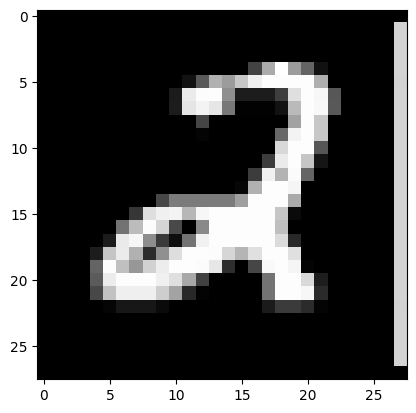

In [48]:
import cv2
img_array = np.asarray(img)
resized = cv2.resize(img_array, (28, 28))
gray_scale = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
image = cv2.bitwise_not(gray_scale)
plt.imshow(image, cmap=plt.get_cmap("gray"))

In [49]:
image = image/255
image = image.reshape(1, 28, 28, 1)

In [50]:
prediction = np.argmax(model.predict(image),axis=1) 
print("predicted digit:", str(prediction))

1/1 [==============================] - 0s 91ms/step
predicted digit: [2]


In [52]:
layer1 = Model(inputs=model.layers[0].input, outputs=model.layers[0].output) # 첫번째 레이어니까 input은 사진 그자체이다.
layer2 = Model(inputs=model.layers[0].input, outputs=model.layers[2].output)

visual_layer1, visual_layer2 = layer1.predict(image), layer2.predict(image)

1/1 [==============================] - 0s 108ms/step


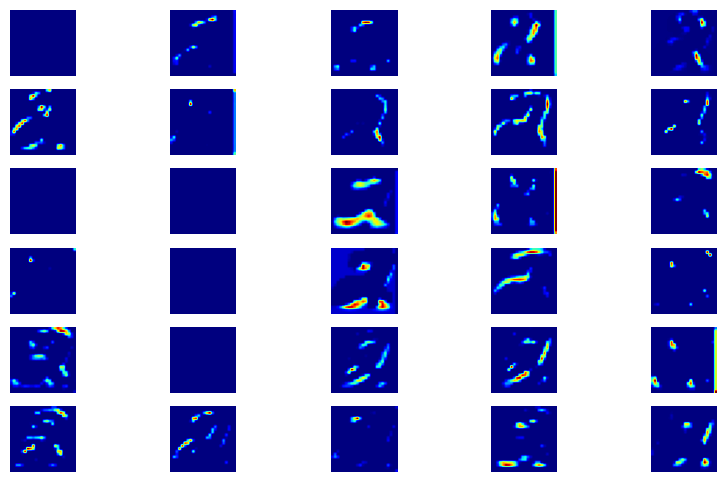

In [53]:
plt.figure(figsize=(10, 6))
for i in range(30):
  plt.subplot(6, 5, i+1)
  plt.imshow(visual_layer1[0, :, :, i], cmap=plt.get_cmap('jet'))
  plt.axis('off')

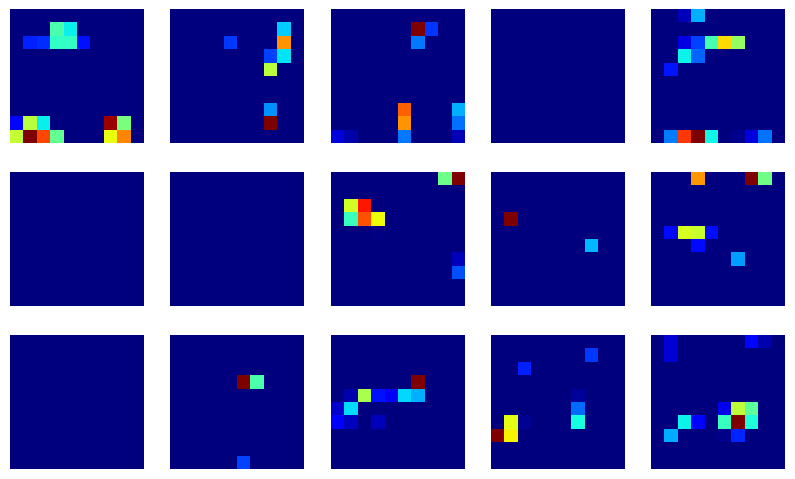

In [54]:
plt.figure(figsize=(10, 6))
for i in range(15):
  plt.subplot(3, 5, i+1)
  plt.imshow(visual_layer2[0, :, :, i], cmap=plt.get_cmap('jet'))
  plt.axis('off')